# WT and Shank3 Knockout LFPs

This notebook will document the analysis of local field potential (LFP) data recorded simultaneously from ventral CA1 (vCA1), dorsal CA1 (dCA1), and medial prefrontal cortex (mPFC) during a working memory task. This data was collected by Vincent Luo and includes animals with one allele of the Shank3 gene knocked out (Hets), as well as wild types (WT).  

The data was originally in a matlab file but we put it into a pandas dataframe that is fairly large (~300MB). We have data sampled from 1 second at 2000Hz, so we have sequences of 2000 numbers. We have ~5000 such sequences under different conditions for the Hets and WT respectively. Ultimately, the goal may be to do some decoding using RNNs, but for now we should explore the data. I did all the preprocessing elsewhere. 

In [3]:
import os
import pickle
import itertools
import pandas as pd
import numpy as np
import sutils.config
import matplotlib.pyplot as plt

ROOT = sutils.config.ROOT
dataframe_files_dir = ROOT + 'Vincent_Project/python_data/'
model_dir = ROOT + 'Models/LSTM/Vincent'

idx = pd.IndexSlice
trial_type = ['correct', 'error']
ROI = ['mPFC', 'vCA1', 'dCA1']
arm = ['GA', 'SA']

## Visualizing Data
Let's just plot 2 examples of data. 

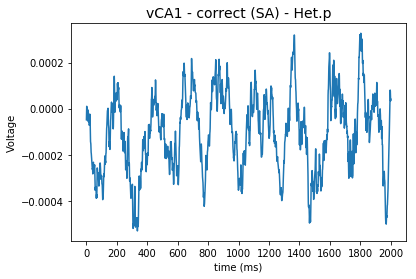

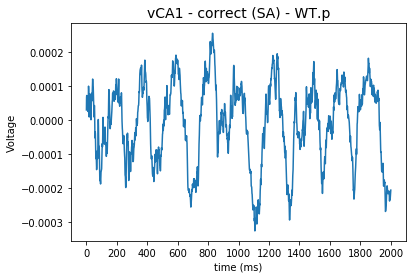

In [20]:
for dataset in os.listdir(dataframe_files_dir):
    df = pickle.load(open(dataframe_files_dir + dataset, 'rb'))
    
    #first let's just plot one example of an LFP
    plt.plot(df.loc[idx['vCA1', 'correct', 'SA', 0], :])
    #we are plotting a correct trial from vCA1 recorded in the start arm
    plt.title('vCA1 - correct (SA) - %s' %dataset, FontSize=14)
    plt.xlabel('time (ms)')
    ms_range = [int(s) for s in np.linspace(0,2000,11)]
    plt.xticks(ms_range, ms_range)
    plt.ylabel('Voltage')
    plt.show()

## Discretizing LFPs
We are dealing with sequences, but there are ~60,000 unique values across ~0.007 volts. We will have to bin the signal. We will do so in the following step, and plot the same LFPs above and see how much information we lost. We are going to have 1000 bins. 

In [21]:
discrete_range = np.linspace(-0.00350000016251, 0.00350000016251, 1000)

for dataset in os.listdir(dataframe_files_dir):
    df = pickle.load(open(dataframe_files_dir + dataset, 'rb'))
    
    for roi, tt, maze_arm in itertools.product(ROI, trial_type, arm):
        noTrials = len(df.loc[idx[roi, tt, maze_arm, :], :])
        for trial in range(noTrials):
            seq = df.loc[idx[roi, tt, maze_arm, trial], :]
            df.loc[idx[roi, tt, maze_arm, trial], :] = np.digitize(seq, discrete_rang               
    pickle.dump(df, open(dataframe_files_dir + dataset[:-2] + '_discrete.p', 'wb'))
    

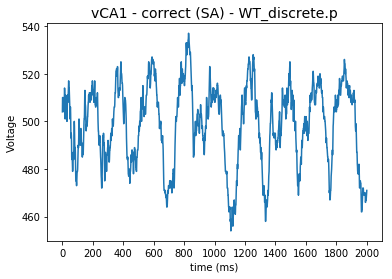

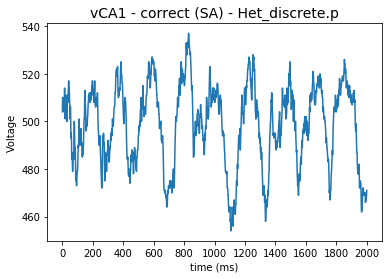

In [22]:
for dataset in [w for w in os.listdir(dataframe_files_dir) if w.find('discrete') > 0]:
    #first let's just plot one example of an LFP
    plt.plot(df.loc[idx['vCA1', 'correct', 'SA', 0], :])
    #we are plotting a correct trial from vCA1 recorded in the start arm
    plt.title('vCA1 - correct (SA) - %s' %dataset, FontSize=14)
    plt.xlabel('time (ms)')
    ms_range = [int(s) for s in np.linspace(0,2000,11)]
    plt.xticks(ms_range, ms_range)
    plt.ylabel('Voltage')
    plt.show()


At least to the naked eye, the plot still looks the same, at least for me, and we reduced the 'vocabulary' of the sequence down to 1000 words. I hope this isn't a parameter that we end up having to play around with. Data looks continuous enough, and I'm sure that the vocab size greatly increases the computation time. 

## Training LSTMs in Parallel

We will now train 12 network sizes for each of the 12 different conditions. That is a total of 144 networks, which we will train for 30 epochs. We will do this in epsilon's 32 cores, and we will be able to get some decoding scores by the morning. Below is more or less the code I ran on epsilon.

EDIT: FML. You can't pickle Keras models, so about 14 hours of computation are in the garbage. You have to use hdf5 format. Never forget this. Pickle is a headache very often. I will now save using this format. I also realized that our data was being stored with 'int64' type, which is overkill because our sequence only goes up to 1000 numbers. I changed it to 'int16' type and cut the size of the data by 4 which will help computation speed I'm sure. OK, I guess we will re-run this. Below is more or less what the code on epsilon looks like. This is what happens when you don't check every stop on the local computer before going parallel. Results were looking promising, I'm not sure what it refers to but the model is outputting a progress bar all the time with the loss and accuracy of the model. I don't know if it is testing accuracy on a validation set that is puts aside, but we were getting accuracy in the 80% range, even saw some 90%s. If this translates to accuracy on the test set, this will be a really good result.  

EDIT 2: Why not? I threw some huuuge networks on epsilon2 as well, dimensions 125, 250, 500, and 1000. 

In [ ]:
#THIS IS EPSILON ROOT DIRECTORY !
ROOT = '/Users/pablomartin/python/'

#standard modules
import sys
if ROOT not in sys.path:
    sys.path.append(ROOT)

import pandas as pd
import numpy as np
import os
import pickle
import time
import itertools
import multiprocessing as mp

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


RANDOM_STATE = 7
test_size = 0.2


dataframe_files_dir = ROOT + 'Vincent_Project/python_data/'
model_dir = ROOT + 'Models/LSTM/Vincent'

idx = pd.IndexSlice
trial_type = ['correct', 'error']
ROI = ['mPFC', 'vCA1', 'dCA1']
arm = ['GA', 'SA']
fileNames = ['Het_discrete.p', 'WT_discrete.p']
hidden_dimensions = [2, 5, 10, 15, 20, 30, 50, 75, 100, 150, 200, 300]




def train_network(HD, dataset_path, ROI, arm, model_path):
    if not os.path.isfile(model_path):
        print 'training %s' %model_path
        df = pickle.load(open(dataset_path, 'rb'))
        tmp_df = df.loc[idx[ROI, :, arm, :], :]
        noTrials = len(tmp_df)
        y = pd.Series(np.zeros(noTrials, dtype=int), index = tmp_df.index)
        y.loc[idx[:,'correct',:,:]] = 1

        print 'separating train/test split'
        #shuffling data and determining train/test split
        shuffleIndex = np.arange(noTrials)
        np.random.seed(RANDOM_STATE)
        np.random.shuffle(shuffleIndex)
        cutoff = int(np.floor(noTrials * (1 - test_size)))

        #doing the actual split
        X_train = tmp_df.iloc[shuffleIndex[:cutoff]]
        y_train = y.iloc[shuffleIndex[:cutoff]]
        X_test = tmp_df.iloc[shuffleIndex[cutoff:]]
        y_test = y.iloc[shuffleIndex[cutoff:]]

        print 'creating model'
        # create the model
        model = Sequential()
        model.add(Embedding(1001, 256, input_length=2001))
        model.add(LSTM(HD))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        model.fit(X_train, y_train, epochs = 30, batch_size=64)
        model.save(model_path)

pool = mp.Pool(processes = 32)

for fileName, roi, maze_arm, hd in \
    itertools.product(fileNames, ROI, arm, hidden_dimensions):
    dataset_path = dataframe_files_dir + fileName
    model_path = \
    '/'.join([model_dir,
              fileName[:fileName.find('_')],
              roi,
              maze_arm,
              'LSTM' + str(hd) + '.h5'])

    pool.apply_async(train_network,
                    [hd, dataset_path, roi, maze_arm, model_path])


## Evaluating Model
The code below will get the performance score on the test set for the 144 different LSTMs that were trained. This will give us an overview of which data is able to decode successful performance the best, and on the other hand, which network dimension aids the most in that process.

In [11]:
from keras.models import load_model

RANDOM_STATE = 7
test_size = 0.2

fileNames = ['Het_discrete.p', 'WT_discrete.p']
#network dimension
hidden_dimensions = [2, 5, 10, 15, 20, 30, 50, 75, 100, 150, 200, 300]
rows = pd.MultiIndex.from_product([fileNames, ROI, arm], names  =['fileName','ROI','arm'])
scores = \
pd.DataFrame(np.zeros([len(rows), len(hidden_dimensions)]), index = rows, columns = hidden_dimensions)

for fileName, roi, maze_arm in itertools.product(fileNames, ROI, arm):
    
    #we must get data back in its original split 
    dataset_path = dataframe_files_dir + fileName
    df = pickle.load(open(dataset_path, 'rb'))
    tmp_df = df.loc[idx[roi, :, maze_arm, :], :]
    noTrials = len(tmp_df)
    y = pd.Series(np.zeros(noTrials, dtype=int), index = tmp_df.index)
    y.loc[idx[:,'correct',:,:]] = 1

    #shuffling data and determining train/test split
    shuffleIndex = np.arange(noTrials)
    np.random.seed(RANDOM_STATE)
    np.random.shuffle(shuffleIndex)
    cutoff = int(np.floor(noTrials * (1 - test_size)))

    #doing the actual split
    X_train = tmp_df.iloc[shuffleIndex[:cutoff]]
    y_train = y.iloc[shuffleIndex[:cutoff]]
    X_test = tmp_df.iloc[shuffleIndex[cutoff:]]
    y_test = y.iloc[shuffleIndex[cutoff:]]

    
    
    #loading the trained model
    model_path = '/'.join([model_dir,
                          fileName[:fileName.find('_')],
                          roi,
                          maze_arm])
    
    for trained_model in os.listdir(model_path):
        hd = int(trained_model[4:trained_model.find('.')])
        model = load_model(model_path + '/' + trained_model)

        tmp_score = model.evaluate(X_test, y_test)
        scores.loc[idx[fileName, roi, maze_arm], hd] = tmp_score[1]
        print '%s - %s - %s - %i' %(fileName, roi, maze_arm, hd)
        print 'model accuracy: %1.2f' %tmp_score[1]

163/163 [==============================] - 10s 63ms/step
Het_discrete.p - mPFC - GA - 75
model accuracy: 0.44
163/163 [==============================] - 11s 67ms/step
Het_discrete.p - mPFC - GA - 10
model accuracy: 0.47
163/163 [==============================] - 11s 65ms/step
Het_discrete.p - mPFC - GA - 100
model accuracy: 0.52
163/163 [==============================] - 11s 67ms/step
Het_discrete.p - mPFC - GA - 30
model accuracy: 0.48
163/163 [==============================] - 12s 72ms/step
Het_discrete.p - mPFC - GA - 20
model accuracy: 0.49
163/163 [==============================] - 11s 69ms/step
Het_discrete.p - mPFC - GA - 15
model accuracy: 0.46
163/163 [==============================] - 11s 66ms/step
Het_discrete.p - mPFC - GA - 50
model accuracy: 0.49
163/163 [==============================] - 12s 73ms/step
Het_discrete.p - mPFC - GA - 150
model accuracy: 0.48
163/163 [==============================] - 11s 68ms/step
Het_discrete.p - mPFC - GA - 5
model accuracy: 0.50
163/163 [

165/165 [==============================] - 18s 110ms/step
WT_discrete.p - mPFC - GA - 100
model accuracy: 0.56
165/165 [==============================] - 17s 106ms/step
WT_discrete.p - mPFC - GA - 30
model accuracy: 0.52
165/165 [==============================] - 17s 103ms/step
WT_discrete.p - mPFC - GA - 20
model accuracy: 0.52
165/165 [==============================] - 18s 106ms/step
WT_discrete.p - mPFC - GA - 15
model accuracy: 0.55
165/165 [==============================] - 18s 106ms/step
WT_discrete.p - mPFC - GA - 50
model accuracy: 0.53
165/165 [==============================] - 21s 129ms/step
WT_discrete.p - mPFC - GA - 150
model accuracy: 0.61
165/165 [==============================] - 17s 105ms/step
WT_discrete.p - mPFC - GA - 5
model accuracy: 0.56
165/165 [==============================] - 22s 131ms/step
WT_discrete.p - mPFC - GA - 2
model accuracy: 0.57
165/165 [==============================] - 40s 242ms/step
WT_discrete.p - mPFC - GA - 300
model accuracy: 0.57
165/165 [

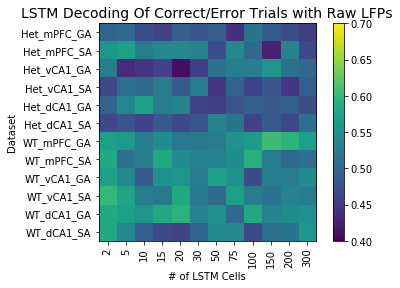

In [24]:
pickle.dump(scores, open(ROOT + 'Model_Evaluation/LSTM/Vincent_singe_LSTM_scores.p', 'wb'))

row_labels = []
tmp = scores.index.levels
for a,b,c in zip(*scores.index.labels):
    row_labels.append('_'.join([tmp[0][a][:tmp[0][a].find('_')], tmp[1][b], tmp[2][c]]))

fig = plt.imshow(scores, vmin = 0.4, vmax = 0.7) 
plt.xticks(np.linspace(0,len(hidden_dimensions) - 1, len(hidden_dimensions)), hidden_dimensions, rotation=90)
plt.yticks(np.linspace(0,len(scores.index) - 1, len(scores.index)), row_labels, rotation=0)

plt.ylabel('Dataset')
plt.xlabel('# of LSTM Cells')
plt.title('LSTM Decoding Of Correct/Error Trials with Raw LFPs', FontSize= 14)
plt.colorbar()
plt.savefig(ROOT + 'Results/LSTM_Vincent.png', dpi=1600)
plt.show()

## Interpretation

That was underwhelming. Given how many networks and computing time went into that last plot! The best decoding accuracy we got was 60%, which honestly is within chance. We may have gotten a smigden of something, however, because WT decoding seemed on average better than Het decoding. There are a couple of papers floating around that also mention poor results with LSTMs and EEG data, and they were trying to decode way more obvious things that we are decoding here. I mean, it seems rat's performance was close to 66% correct. How many of those trials went either way by chance ? How would that show up in the signal ? 

## Next Steps  

What we will try next is, instead of using voltage values as the elements of the sequence, we will use the power values for beta, theta, gamma frequency bands. Then, we will hope the LSTM learns the relationship between those values and see if that aids decoding some. 

EDIT: so we reached out to Vincent and got him to give us more information about the data. Before we were lumping all variable delays together, as well as animals. We just got this information and we will reprocess the dataset to get all this information in. It will be useful for decoding, maybe.

An idea someone from CTRL-Labs open house told me yesterday: not only feed the EEG to the network, but also a convolution of the LFP with itself with some variable time lag. There was some paper showing that this works really well, so we will need to find this paper. 

## New Run
I have added all the task information to the dataset, and made one VERY large dataframe that is close to 0.5 GB. It includes all the data, though, and we can slice it anyway we want now, conveniently. For the most part, we will try the following: include animal and task, etc. as features. 